## Predicting Default in Online Personal Loans

The purpose of this code is to use Logistic Regression and XGBoost to predict default in Lending Club loans, and to compare the performance between the two models. The motivation for this exercise is to get a better understanding of how much better XGBoost performs compared to traditional statistical tools by applying it to a realistic problem.  

In [528]:
import os 

# Analytic tools
%matplotlib inline

import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns

# tools for OOS prediction
from sklearn.model_selection import train_test_split

# Models 
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

# Handling Class Imbalance
from sklearn.utils import resample

# Feature Engineering
from sklearn.tree import DecisionTreeClassifier

# performance metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix  
from sklearn.metrics import accuracy_score, classification_report, log_loss

from sklearn.model_selection import GridSearchCV # cross val
from sklearn.metrics import plot_confusion_matrix # draw confusion matrix

## Data Preprocessing and Exploration

In [483]:
# import datasets
dta = pd.read_csv("lending_club\\loan.csv")
print(dta.shape)
dta.head()

(39717, 111)


C:\Users\Danie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [484]:
# Drop columns where more than half the data is missing 
dta.isnull()
dta.isnull().sum()
half = int(dta.shape[0]/2)
dta.dropna(axis = 1, thresh = half, inplace = True)

dta.columns = dta.columns.str.replace(' ', '')
dta.replace(' ', '_', regex=True, inplace=True)

In [485]:
# Before cleaning data, identify credit, loan and geo/demographic characteristics to use as features
# and loan status to use as target:
dta.dtypes
dta.columns.values.tolist()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens']

In [486]:
# don't include columns such as id and member id 
features = ['loan_amnt',
            'term',
            'sub_grade',
            'emp_length',
            'home_ownership',
            'annual_inc',
            'dti',
            'delinq_2yrs',            
            'inq_last_6mths',            
            'open_acc',
            'pub_rec',
            'revol_bal',
            'revol_util',
            'total_acc',
            'chargeoff_within_12_mths',
            'pub_rec_bankruptcies',
            'tax_liens',
            'addr_state',
            'purpose']

In [487]:
dta[features]

,loan_amnt,term,sub_grade,emp_length,home_ownership,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens,addr_state,purpose
0,5000,_36_months,B2,10+_years,RENT,24000.0,27.65,0,1,3,0,13648,83.70%,9,0.0,0.0,0.0,AZ,credit_card
1,2500,_60_months,C4,<_1_year,RENT,30000.0,1.00,0,5,3,0,1687,9.40%,4,0.0,0.0,0.0,GA,car
2,2400,_36_months,C5,10+_years,RENT,12252.0,8.72,0,2,2,0,2956,98.50%,10,0.0,0.0,0.0,IL,small_business
3,10000,_36_months,C1,10+_years,RENT,49200.0,20.00,0,1,10,0,5598,21%,37,0.0,0.0,0.0,CA,other
4,3000,_60_months,B5,1_year,RENT,80000.0,17.94,0,0,15,0,27783,53.90%,38,0.0,0.0,0.0,OR,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39712,2500,_36_months,A4,4_years,MORTGAGE,110000.0,11.33,0,0,13,0,7274,13.10%,40,NaN,NaN,NaN,CO,home_improvement
39713,8500,_36_months,C1,3_years,RENT,18000.0,6.40,1,1,6,0,8847,26.90%,9,NaN,NaN,NaN,NC,credit_card
39714,5000,_36_months,A4,<_1_year,MORTGAGE,100000.0,2.30,0,0,11,0,9698,19.40%,20,NaN,NaN,NaN,MA,debt_consolidation
39715,5000,_36_months,A2,<_1_year,MORTGAGE,200000.0,3.72,0,0,17,0,85607,0.70%,26,NaN,NaN,NaN,MD,other


In [488]:
# replace missing vals with mode if categorical 
# replace missing vals with mean if continuous or discrete 
dta[features].isnull().sum()
dta[features]

# some additional cleaning 
dta['revol_util'] = dta['revol_util'].str.rstrip('%').astype('float') / 100.0

# dealing with missing values
dta['emp_length'] = dta['emp_length'].fillna(dta['emp_length'].mode())
dta['revol_util'] = dta['revol_util'].fillna(dta['revol_util'].mean())
dta['chargeoff_within_12_mths'] = dta['chargeoff_within_12_mths'].fillna(dta['chargeoff_within_12_mths'].mean())
dta['pub_rec_bankruptcies'] = dta['pub_rec_bankruptcies'].fillna(dta['pub_rec_bankruptcies'].mean())
dta['tax_liens'] = dta['tax_liens'].fillna(dta['tax_liens'].mean())

In [489]:
# Code target
# 1 means Default
# 0 means Paid 
dta['loan_status'].value_counts()
dta['target'] = 0
dta['target'].loc[dta['loan_status'] == 'Charged_Off'] = 1
dta['target'].value_counts()

C:\Users\Danie\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0    34090
1     5627
Name: target, dtype: int64

## Rebalance Classes

The previous section shows significant imbalance between a current/paid off loan and a defaulted loan. It would be hard to learn the latter unless we rebalance the classes

In [490]:
# up-sampling
currents = dta[dta['target'] == 0]
defaults = dta[dta['target'] == 1]

In [491]:
upsampled_dta = resample(defaults, replace = True, n_samples = currents.shape[0], random_state = 99999)
upsampled_dta = pd.concat([currents, upsampled_dta])
upsampled_dta['target'].value_counts()

0    34090
1    34090
Name: target, dtype: int64

In [492]:
upsampled_dta[features].dtypes
upsampled_dta[features].describe().T
my_features = upsampled_dta[features]
# one-hot encode categorical features
to_encode = ['home_ownership', 'emp_length', 'term', 'addr_state', 'sub_grade', 'purpose']
my_features = pd.get_dummies(my_features, columns = to_encode)

# Now split data
X = my_features
y = upsampled_dta['target'].astype(int)
print(X.shape)
print(y.shape)

(68180, 130)
(68180,)


## Feature Engineering and Selection

In [550]:
dt = DecisionTreeClassifier(random_state = 432, criterion = 'entropy', max_depth = 15)
dt.fit(X,y)

fi_col = []
fi = []

for i, column in enumerate(my_features):
    # print("The feature importance for {} is {}".format(column, dt.feature_importances_[i]))    
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])
    
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature', 'Feature Importance'])
fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()

IndexError: index 100 is out of bounds for axis 0 with size 100

In [494]:
fi_df[:100]

,Feature,Feature Importance
8,revol_util,0.110532
1,annual_inc,0.104306
7,revol_bal,0.090501
2,dti,0.075214
29,term__36_months,0.070915
...,...,...
126,purpose_renewable_energy,0.000626
39,addr_state_DE,0.000605
121,purpose_house,0.000578
96,sub_grade_D1,0.000483


In [495]:
keep_cols = fi_df['Feature'][0:100]
keep_cols

X = X[keep_cols]
print(X.shape)
print(y.shape) # only 1 columns

(68180, 100)
(68180,)


In [496]:
# 80% for training, 20% for hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 11)

# 10-fold cross val
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.9, test_size = 0.1, random_state = 12)


print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(49089, 100)
(13636, 100)
(5455, 100)
(49089,)
(13636,)
(5455,)


## Logistic Regression

In [541]:
log_reg = LogisticRegression(random_state = 999, solver = 'lbfgs')

# lbfgs is the Limited-Broyden–Fletcher–Goldfarb–Shanno algorithm. 
# This is an iterative search algorithm with O(n^2) complexity compared to O(n^3) in the Newton method, 
# since it avoids matrix inversion. In my experience, it performs better than the Newton method
# for statistical inference when variation in features is not large.

# train model
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=999)

In [542]:
# Skip hyperparameter tuning..

y_pred = log_reg.predict(X_test)
probs = log_reg.predict_proba(X_test)

## Evaluation

In [544]:
print("The Training Accuracy is: ", log_reg.score(X_train, y_train))
print("The Testing Accuracy is: ", log_reg.score(X_test, y_test))

# Classification Report 
print(classification_report(y_test, y_pred))

The Training Accuracy is:  0.557782802664548
The Testing Accuracy is:  0.5616749779994133
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      6961
           1       0.55      0.55      0.55      6675

    accuracy                           0.56     13636
   macro avg       0.56      0.56      0.56     13636
weighted avg       0.56      0.56      0.56     13636



In [545]:
def plot_conf_mtx(cm, classes = None, title = 'Confusion Matrix'):
    """ plot confusion matrix"""    
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels = classes, yticklabels = classes, vmin = 0, vmax = 1., annot = True, annot_kws={'size':50})        
    else:
        sns.heatmap(cm, vmin = 0., vmax = 1.)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')        

## Evaluation: Confusion Matrix and AUC

Logistic Regression did not do that well! Precision = 0.54, Recall = 0.56, AUC = 0.56

In [547]:
print(cm)
# print(cm.sum(axis=0))

[[14042 10412]
 [11296 13339]]


[[4008 2953]
 [3024 3651]]
Precision:  0.5469662921348315
Recall:  0.5528467595396729
AUC:  0.5613728170916938


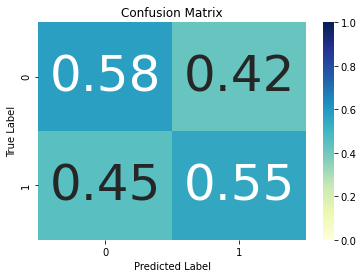

In [555]:
cm = confusion_matrix(y_test, y_pred)

cm_norm = cm / cm.sum(axis = 1).reshape(-1,1)

print(confusion_matrix(y_test, y_pred))
plot_conf_mtx(cm_norm, classes = log_reg.classes_)

precision = confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[1][0] + confusion_matrix(y_test, y_pred)[1][1])
recall  = confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[0][1] + confusion_matrix(y_test, y_pred)[1][1])
print("Precision: ", precision) # out of all the data points flagged as positive, what proportion are indeed positive?
print("Recall: ", recall) # out of all the data points that are actually positive, what proportion did you flag?
print("AUC: ", roc_auc_score(y_test, y_pred)) # Trade-off b/t false positive and true positive rate

## XGBoost 

In [577]:
X_train.columns = X_train.columns.str.replace(",", "")
X_train.columns = X_train.columns.str.replace(">", "")
X_train.columns = X_train.columns.str.replace("<", "")

X_test.columns = X_train.columns.str.replace(",", "")
X_test.columns = X_train.columns.str.replace(">", "")
X_test.columns = X_train.columns.str.replace("<", "")

In [578]:
xtreme = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric="logloss", ## this avoids a warning...
                            seed=42, 
                            use_label_encoder=False)

In [582]:
xtreme.fit(X_train, 
           y_train, 
           verbose = True, 
           early_stopping_rounds =10, 
           eval_metric= 'aucpr', 
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.64782
[1]	validation_0-aucpr:0.66251
[2]	validation_0-aucpr:0.66950
[3]	validation_0-aucpr:0.67527
[4]	validation_0-aucpr:0.68009
[5]	validation_0-aucpr:0.68558
[6]	validation_0-aucpr:0.68895
[7]	validation_0-aucpr:0.69420
[8]	validation_0-aucpr:0.70034
[9]	validation_0-aucpr:0.70601
[10]	validation_0-aucpr:0.70873
[11]	validation_0-aucpr:0.71225
[12]	validation_0-aucpr:0.71461
[13]	validation_0-aucpr:0.71778
[14]	validation_0-aucpr:0.72080
[15]	validation_0-aucpr:0.72350
[16]	validation_0-aucpr:0.72676
[17]	validation_0-aucpr:0.72782
[18]	validation_0-aucpr:0.72915
[19]	validation_0-aucpr:0.73245
[20]	validation_0-aucpr:0.73573
[21]	validation_0-aucpr:0.73889
[22]	validation_0-aucpr:0.74087
[23]	validation_0-aucpr:0.74267
[24]	validation_0-aucpr:0.74376
[25]	validation_0-aucpr:0.74565
[26]	validation_0-aucpr:0.74870
[27]	validation_0-aucpr:0.74952
[28]	validation_0-aucpr:0.75102
[29]	validation_0-aucpr:0.75344
[30]	validation_0-aucpr:0.75585
[31]	validation_0-

## Evaluation of XGBoost: Confusion Matrix and AUC

In [588]:
xgb_y_pred = xtreme.predict(X_test)

[[5156 1805]
 [1135 5540]]
Precision:  0.8299625468164794
Recall:  0.7542545949625595
AUC:  0.7853303611829847


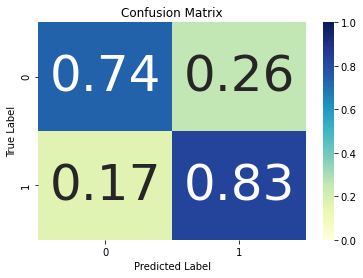

In [590]:
cm = confusion_matrix(y_test, xgb_y_pred)

cm_norm = cm / cm.sum(axis = 1).reshape(-1,1)

print(confusion_matrix(y_test, xgb_y_pred))
plot_conf_mtx(cm_norm, classes = log_reg.classes_)

precision = confusion_matrix(y_test, xgb_y_pred)[1][1]/(confusion_matrix(y_test, xgb_y_pred)[1][0] + confusion_matrix(y_test, xgb_y_pred)[1][1])
recall  = confusion_matrix(y_test, xgb_y_pred)[1][1]/(confusion_matrix(y_test, xgb_y_pred)[0][1] + confusion_matrix(y_test, xgb_y_pred)[1][1])
print("Precision: ", precision) # out of all the data points flagged as positive, what proportion are indeed positive?
print("Recall: ", recall) # out of all the data points that are actually positive, what proportion did you flag?
print("AUC: ", roc_auc_score(y_test, xgb_y_pred)) # Trade-off b/t false positive and true positive rate